Notebook do curso Keras Tunner do Coursera
- ref. https://www.tensorflow.org/tutorials/keras/classification?hl=pt-br
- ref. https://www.tensorflow.org/tutorials/keras/keras_tuner

In [1]:
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.__version__

'2.5.0'

## prepara o conjunto de dados

In [3]:
(x_train, y_train), (x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

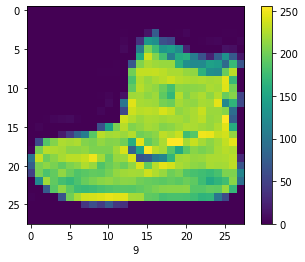

In [6]:
#plt.imshow(x_train[2],cmap='binary')
plt.figure()
plt.imshow(x_train[0])
plt.xlabel(y_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

## Defina o modelo
Ao construir um modelo para hiper-sintonia, você também define o espaço de pesquisa do hiperparâmetro, além da arquitetura do modelo. O modelo que você configurou para hypertuning é chamado de hypermodel.

Você pode definir um hipermodelo por meio de duas abordagens:

In [7]:
def create_model(hp): #hp como parametro, logo podemos estabelecer diversos valores
    
    num_hidden_layers = 1
    num_units = 8
    dropout_rate = 0.1
    learning_rate = 0.01
    
    if hp: #se esse parametro for passado - esse conjunto de parametros define o tuner
        num_hidden_layers = hp.Choice("num_hidden_layers", values = [1,2,3])
        num_units = hp.Choice('num_units',values = [8,16,32])
        dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value = 0.5)
        learning_rate = hp.Float('learning_rate',min_value= 0.0001, max_value=0.01)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    model.add(tf.keras.layers.Lambda(lambda x:x/255.)) ## Normalize pixel values between 0 and 1
    
    for _ in range(0,num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_units,activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
        
    model.add(tf.keras.layers.Dense(10, activation='softmax')) #camada de saída - classificação 
    
    model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                #loss='sparse_categorical_crossentropy',  
                metrics=['accuracy'])
    
    return model

In [8]:
create_model(None).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [9]:
class CustomTuner(keras_tuner.tuners.BayesianOptimization):
    def run_trian(self,trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size',32,128,step=32)
        super(CustomTuner,self).run_trial(trial,*args,**kwargs)

In [10]:
tuner = CustomTuner(
    create_model,
    objective= 'val_accuracy',
    max_trials = 20,
    directory = 'logs',
    project_name = 'fashion_mnist',
    overwrite = True
)

In [11]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}


In [12]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [13]:
tuner.search(
    x_train, y_train,
    validation_data=(x_test,y_test),
    callbacks=[stop_early],
    epochs=5, verbose=False
)

INFO:tensorflow:Oracle triggered exit


In [14]:
tuner.results_summary(3) #exibe os três melhores resultados

Results summary
Results in logs\fashion_mnist
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_hidden_layers: 2
num_units: 32
dropout_rate: 0.14717621946944304
learning_rate: 0.0016407017659114903
Score: 0.8547000288963318
Trial summary
Hyperparameters:
num_hidden_layers: 2
num_units: 32
dropout_rate: 0.1464804366932363
learning_rate: 0.0018203220343830265
Score: 0.8539999723434448
Trial summary
Hyperparameters:
num_hidden_layers: 2
num_units: 32
dropout_rate: 0.14680490773387259
learning_rate: 0.001495147218875434
Score: 0.8532999753952026


## Primeira abordagem, agora que sabemos os melhores parametros, hora de utilizá-los.

In [15]:
# Get the optimal hyperparameters
#best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('num_units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 32 and the optimal learning rate for the optimizer
is 0.0016407017659114903.



In [16]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model             = tuner.hypermodel.build(best_hps)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3

In [18]:
history           = model.fit(x_train, y_train, epochs=50, validation_split=0.2)
val_acc_per_epoch = history.history['val_accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/50
1500/1500 [==============================] - 3s 1ms/step - loss: 0.7162 - accuracy: 0.7443 - val_loss: 0.4551 - val_accuracy: 0.8381
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5167 - accuracy: 0.8126 - val_loss: 0.4189 - val_accuracy: 0.8448
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4819 - accuracy: 0.8255 - val_loss: 0.4135 - val_accuracy: 0.8482
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4594 - accuracy: 0.8340 - val_loss: 0.4186 - val_accuracy: 0.8438
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4442 - accuracy: 0.8394 - val_loss: 0.4030 - val_accuracy: 0.8584
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4351 - accuracy: 0.8431 - val_loss: 0.3959 - val_accuracy: 0.8565
Epoch 7/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4277 - accuracy: 0.8430 - val_loss: 0.3935 - val_accuracy:

In [19]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 39


In [20]:
eval_result = model.evaluate(x_test,y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 0s 1ms/step - loss: 0.4034 - accuracy: 0.8609
[test loss, test accuracy]: [0.40344417095184326, 0.8608999848365784]


In [21]:
hypermodel = tuner.hypermodel.build(best_hps)
# Retrain the model
hypermodel.fit(x_train,y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/39
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6862 - accuracy: 0.7546 - val_loss: 0.4687 - val_accuracy: 0.8353
Epoch 2/39
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5018 - accuracy: 0.8204 - val_loss: 0.4284 - val_accuracy: 0.8476
Epoch 3/39
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4670 - accuracy: 0.8339 - val_loss: 0.4184 - val_accuracy: 0.8512
Epoch 4/39
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4490 - accuracy: 0.8395 - val_loss: 0.3962 - val_accuracy: 0.8585
Epoch 5/39
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4351 - accuracy: 0.8439 - val_loss: 0.3849 - val_accuracy: 0.8626
Epoch 6/39
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4234 - accuracy: 0.8488 - val_loss: 0.3797 - val_accuracy: 0.8612
Epoch 7/39
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4153 - accuracy: 0.8474 - val_loss: 0.3791 - val_accuracy:

In [22]:
eval_result = hypermodel.evaluate(x_test,y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 0s 1ms/step - loss: 0.3961 - accuracy: 0.8632
[test loss, test accuracy]: [0.39611566066741943, 0.8632000088691711]


## Outra abordagem, onde o modelo é recompilado

In [23]:
# Retrieve the best model and hyperparameters
best_model           = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print('HyperParameters: {}'.format(best_hyperparameters.values))

HyperParameters: {'num_hidden_layers': 2, 'num_units': 32, 'dropout_rate': 0.14717621946944304, 'learning_rate': 0.0016407017659114903}


In [24]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3

In [25]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 676us/step - loss: 0.4078 - accuracy: 0.8547


In [26]:
best_model.compile(
        loss='sparse_categorical_crossentropy',    
        optimizer=tf.keras.optimizers.Adam(learning_rate = best_hyperparameters.get('learning_rate')),
        metrics=['accuracy']
    )

In [27]:
_ = best_model.fit(
    x_train,y_train,
    validation_data = (x_test,y_test),
    epochs=20, batch_size = 128,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)]
)

Epoch 1/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3994 - accuracy: 0.8564 - val_loss: 0.3964 - val_accuracy: 0.8577
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3903 - accuracy: 0.8600 - val_loss: 0.3851 - val_accuracy: 0.8639
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3856 - accuracy: 0.8609 - val_loss: 0.3828 - val_accuracy: 0.8644
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3782 - accuracy: 0.8630 - val_loss: 0.3852 - val_accuracy: 0.8643
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3756 - accuracy: 0.8624 - val_loss: 0.3897 - val_accuracy: 0.8611
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3754 - accuracy: 0.8641 - val_loss: 0.3785 - val_accuracy: 0.8658
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3721 - accuracy: 0.8650 - val_loss: 0.3808 - val_accuracy: 0.8673
Epoch 

In [28]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 780us/step - loss: 0.3839 - accuracy: 0.8620


In [29]:
best_model.fit(
    x_train,y_train,
    validation_data = (x_test,y_test),
    epochs=20, batch_size = 128,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)]
)

Epoch 1/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3564 - accuracy: 0.8709 - val_loss: 0.3753 - val_accuracy: 0.8679
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3553 - accuracy: 0.8697 - val_loss: 0.3788 - val_accuracy: 0.8636
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3530 - accuracy: 0.8702 - val_loss: 0.3763 - val_accuracy: 0.8674
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3517 - accuracy: 0.8712 - val_loss: 0.3762 - val_accuracy: 0.8683
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3482 - accuracy: 0.8722 - val_loss: 0.3710 - val_accuracy: 0.8688
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3473 - accuracy: 0.8745 - val_loss: 0.3744 - val_accuracy: 0.8698
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3437 - accuracy: 0.8750 - val_loss: 0.3717 - val_accuracy: 0.8698
Epoch 

In [30]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 873us/step - loss: 0.3772 - accuracy: 0.8691
